In [2]:
#Импорт библиотек
import pandas as pd
import requests
import numpy as np
from datetime import datetime
from datetime import timedelta


%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

Игнорируем warnings

In [3]:
import warnings
warnings.filterwarnings("ignore")

Загрузим необходимые файлы и проведем предварительный анализ данных

In [4]:
olist_customers_datase = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ev-saveleva/first_project/olist_customers_dataset.csv')

Датафрейм с уникальными идентификаторами пользователей

olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

In [5]:
olist_customers_datase.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [6]:
olist_customers_datase.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [7]:
olist_customers_datase.shape

(99441, 5)

In [8]:
olist_customers_datase.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [9]:
olist_customers_datase.groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id': 'count'}) \
    .sort_values('customer_id', ascending=False) \
    .rename(columns={'customer_id': 'number_of_orders'}) \
    .head(5)

,customer_unique_id,number_of_orders
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7


In [10]:
olist_orders_dataset = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ev-saveleva/first_project/olist_orders_dataset.csv')

Датафрейм с таблицей заказов

olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

In [11]:
olist_orders_dataset.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [12]:
olist_orders_dataset.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Пропущенные значения в колонках order_approved_at (время подтверждения оплаты заказа), order_delivered_carrier_date (время передачи заказа в логистическую службу), order_delivered_customer_date (время доставки заказа) объяснимы, так как:

1.) Если есть пропуск в order_approved_at, это говорит о том, что пользователь мог положить товар(ы) в корзину, но потом передумал оплачивать заказ.

2.) Если есть пропуск в order_delivered_carrier_date, это может означать, что заказ создан, но еще не передан курьеру.

3.) Если есть пропуск в order_delivered_customer_date, это тоже логично, потому что заказ может быть еще в пути.

Все аномалии с пропусками объяснимы.

In [13]:
olist_orders_dataset.shape

(99441, 8)

In [14]:
olist_orders_dataset.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

Переведем колонки, связанные со временем в тип данных datetime

In [15]:
olist_orders_dataset.order_purchase_timestamp = pd.to_datetime(olist_orders_dataset.order_purchase_timestamp)
olist_orders_dataset.order_approved_at = pd.to_datetime(olist_orders_dataset.order_approved_at)
olist_orders_dataset.order_delivered_customer_date = pd.to_datetime(olist_orders_dataset.order_delivered_customer_date)
olist_orders_dataset.order_delivered_carrier_date = pd.to_datetime(olist_orders_dataset.order_delivered_carrier_date)
olist_orders_dataset.order_estimated_delivery_date = pd.to_datetime(olist_orders_dataset.order_estimated_delivery_date)

In [16]:
olist_orders_dataset.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Проверим, когда были совершены заказы, чтобы определить период, за который мы анализируем данные

In [17]:
olist_orders_dataset[['order_purchase_timestamp']].describe()

,order_purchase_timestamp
count,99441
unique,98875
top,2018-03-31 15:08:21
freq,3
first,2016-09-04 21:15:19
last,2018-10-17 17:30:18


Итог: исследуем данные - с сентября 2016 по октябрь 2018

Проверим сколько у нас каждого типа заказов

In [18]:
olist_orders_dataset.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

Всего доставленных заказов - 96478, а все ли они оплачены?

Мы можем считать заказ успешным, т.е. покупкой, если он доставлен (об этом нам говорит статус delivered в колонке order_status), а также оплачен (смотрим по наличию времени в колонке order_approved_at)

In [19]:
olist_orders_dataset.query('order_status=="delivered"').isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

Есть пропущенные значения, что говорит об **ошибке в данных**:
- если в order_approved_at пропуски, это противоречит со сформулированным определением покупки выше
- также есть пропуски в order_delivered_carrier_date(время передачи заказа в логистическую службу) и в order_delivered_customer_date(время доставки заказа)

Удаляем строки с пропусками:

In [20]:
orders = olist_orders_dataset.query('order_status=="delivered"').dropna()

In [21]:
orders.shape

(96455, 8)

Теперь в датафрейме orders находятся только те строки, которые считаются покупкой.

In [22]:
olist_order_items_dataset = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ev-saveleva/first_project/olist_order_items_dataset.csv')

Датафрейм с указанием товарных позиций, которые входят в заказы

olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

In [23]:
olist_order_items_dataset.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


Приведем максимальную дату доставки продавцом для передачи заказа партнеру по логистике к типу данных datetime

In [24]:
olist_order_items_dataset.shipping_limit_date = pd.to_datetime(olist_order_items_dataset.shipping_limit_date)

In [25]:
olist_order_items_dataset.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [26]:
olist_order_items_dataset.shape

(112650, 7)

In [27]:
olist_order_items_dataset.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [28]:
olist_order_items_dataset.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


Проверим, есть ли у нас дублирующиеся строки?

In [29]:
print(olist_customers_datase.duplicated().sum())
print(olist_orders_dataset.duplicated().sum())
print(olist_order_items_dataset.duplicated().sum())

0
0
0


Дублей нет

**Сколько у нас пользователей, которые совершили покупку только один раз?**

Чтобы посчитать количество пользователей, которые совершили покупку только один раз, нужно проверить нет ли в данных еще каких-либо аномалий.

In [30]:
orders.query('order_delivered_carrier_date >= order_delivered_customer_date').count().iloc[0]

32

Существуют 32 строки, в которых заказ был передан в логистическую службу, позже чем доставлен, что считается ошибкой, удалим эти строки.

In [31]:
orders = orders.query('order_delivered_carrier_date < order_delivered_customer_date')

In [32]:
orders.shape

(96423, 8)

Проверим далее на аномалии, связанные со временем.

In [33]:
orders.query('order_purchase_timestamp > order_approved_at').count()[0]

0

In [34]:
orders.query('order_purchase_timestamp > order_estimated_delivery_date').count()[0]

0

Заказы, которые доставлялись позже, чем было запланировано

In [35]:
orders.query('order_delivered_customer_date > order_estimated_delivery_date').count()[0]

7825

Это не ошибка, но бизнесу стоит задуматься о том, как он может автоматизировать, оптимировать логистическую службу.

Для того, чтобы ответить на вопрос о том, сколько у нас пользователей, которые совершили покупку только один раз, нам нужно к таблице с заказами присоединить таблицу с юзерами. Объединять будем по полю customer_id

In [36]:
orders_only_one_order = orders.merge(olist_customers_datase, how='inner', on='customer_id')

In [37]:
orders_only_one_order = orders_only_one_order.groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id': 'count'}) \
    .sort_values('customer_id', ascending=False) \
    .rename(columns={'customer_id': 'count_orders'})

In [38]:
orders_only_one_order.query('count_orders==1').shape[0]

90512

**Ответ на первое задание: 90512**

Пользователей, которые совершили одну покупку гораздо больше остальных (лояльных) пользователей, это говорит о том, что у компании очень низкий retention, поэтому есть повод задуматься.

**Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?**

Причины, по которым заказ может быть не доставлен:
   - статус 'unavailable'
   - статус 'canceled'
   - заказы с пустыми значениями, имеющие статус 'delivered', то есть наши ошибки

Посчитаем, сколько у нас строк с ошибками в данных

In [39]:
olist_orders_dataset.query('order_status=="delivered"')\
    .isna()\
    .query('order_approved_at==True or order_delivered_carrier_date==True or order_delivered_customer_date')\
    .shape[0]

23

Заберем индексты этих заказов, чтобы их статус с 'delivered' поменять на 'error'

In [40]:
indexes = olist_orders_dataset.query('order_status=="delivered"')\
    .isna()\
    .query('order_approved_at==True or order_delivered_carrier_date==True or order_delivered_customer_date')\
    .order_status.index.tolist()

In [41]:
olist_orders_dataset.at[indexes, 'order_status'] = 'errors'

In [42]:
olist_orders_dataset.query('order_status=="errors"').shape

(23, 8)

In [43]:
not_delivered_orders = olist_orders_dataset.loc[olist_orders_dataset['order_status'].isin(['canceled','unavailable','errors'])]

In [44]:
not_delivered_orders.shape

(1257, 8)

Нам нужно вычислить недоставленные заказы в среднем по месяцам, поэтому добавим колонку с нужным нам типом данным

In [45]:
not_delivered_orders['month'] = not_delivered_orders['order_purchase_timestamp'].dt.to_period('M')

In [46]:
not_delivered_orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,2017-11


In [47]:
not_delivered_orders = not_delivered_orders[['order_id', 'order_status', 'month']]

In [48]:
not_delivered_orders_all = not_delivered_orders.groupby(['month', 'order_status'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'count_orders'})

In [49]:
not_delivered_orders_all.head(5)

,month,order_status,count_orders
0,2016-09,canceled,2
1,2016-10,canceled,24
2,2016-10,unavailable,7
3,2017-01,canceled,3
4,2017-01,errors,2


In [50]:
not_delivered_orders_all['count_orders'].mean().round()

24.0

В среднем не доставляются 24 заказа в месяц

А теперь перейдем к детализации:

In [51]:
not_delivered_orders_all_mean = not_delivered_orders_all.groupby('order_status', as_index=False) \
                                            .agg({'count_orders' : 'mean'}) \
                                            .rename(columns={"count_orders": "canceled_mean"}).round()

In [52]:
not_delivered_orders_all_mean

,order_status,canceled_mean
0,canceled,26.0
1,errors,3.0
2,unavailable,29.0


 **Ответ: По причине отмен в среднем не доставляется 26 заказов. По причине недоступности заказов - 29.  По причине ошибок в данных - 3 заказа.**

In [53]:
sns.set(rc={'figure.figsize':(16,9)}, style="whitegrid")

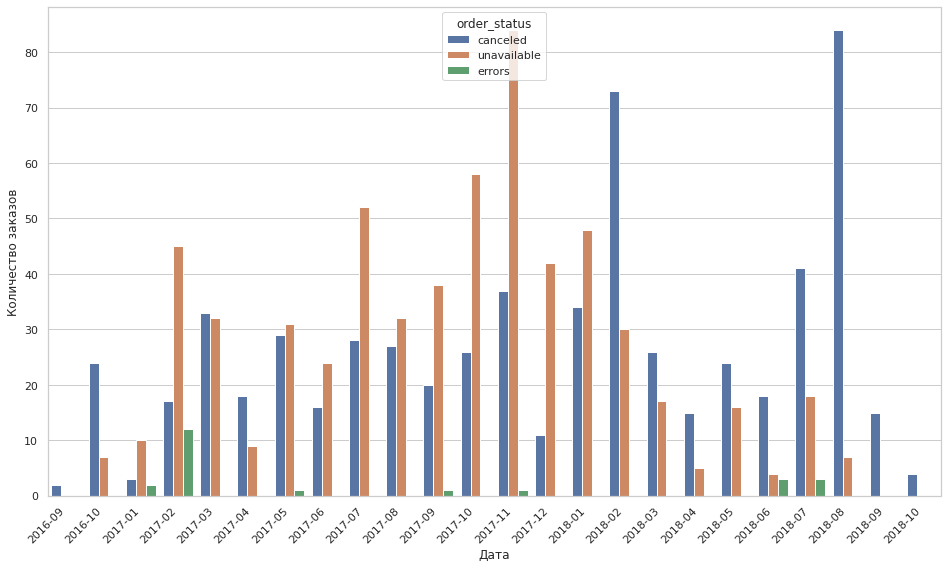

In [54]:
model = sns.barplot(data = not_delivered_orders_all, x="month", y="count_orders", hue = "order_status")
model.set_xticklabels(model.get_xticklabels(), rotation=45, ha="right")
model.set(xlabel='Дата', ylabel='Количество заказов')
plt.show()

**По каждому товару определить, в какой день недели товар чаще всего покупается.**

In [55]:
olist_order_items_dataset.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


In [56]:
orders_week = orders.merge(olist_order_items_dataset, how='left', on='order_id')

В некоторых заказах, у нас не по одному товару:

In [57]:
olist_order_items_dataset.groupby('order_id').agg({'order_item_id':'count'}).sort_values('order_item_id', ascending = False)

,order_item_id
order_id,
8272b63d03f5f79c56e9e4120aec44ef,21
1b15974a0141d54e36626dca3fdc731a,20
ab14fdcfbe524636d65ee38360e22ce8,20
9ef13efd6949e4573a18964dd1bbe7f5,15
428a2f660dc84138d969ccd69a0ab6d5,15
...,...
5a0911d70c1f85d3bed0df1bf693a6dd,1
5a082b558a3798d3e36d93bfa8ca1eae,1
5a07264682e0b8fbb3f166edbbffc6e8,1


In [58]:
orders_week['day_of_week'] = orders_week['order_purchase_timestamp'].dt.day_name()

In [59]:
orders_week.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday


In [60]:
orders_day_of_week = orders_week.groupby(['product_id', 'day_of_week'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .sort_values('order_id', ascending=False)

In [61]:
orders_day_of_week

,product_id,day_of_week,order_id
15580,422879e10f46682990de24d770e7f83d,Wednesday,93
35719,99a4788cb24856965c36a24e339b6058,Monday,91
40148,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
40149,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
40144,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,83
...,...,...,...
23476,641aef802951b7cb93574143819fac79,Saturday,1
23477,641aef802951b7cb93574143819fac79,Sunday,1
23479,6421588f55f75de28cb3357e07723d14,Monday,1
23480,6421588f55f75de28cb3357e07723d14,Saturday,1


In [62]:
orders_day_of_week_without_duplicates = orders_day_of_week.drop_duplicates(subset = "product_id" ).sort_values('order_id', ascending = False)
orders_day_of_week_without_duplicates

,product_id,day_of_week,order_id
15580,422879e10f46682990de24d770e7f83d,Wednesday,93
35719,99a4788cb24856965c36a24e339b6058,Monday,91
40148,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
19688,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
13255,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...
55276,eced39e6c33db4b865ea46d12dde67d8,Monday,1
42020,b4710f5c669c6820baa19c6c83c387ef,Saturday,1
42019,b46df49597c48fda458171cd058059c4,Saturday,1
42018,b469675b10244fe989f232d3b38b41f4,Wednesday,1


**Результирующий датасет записан в orders_day_of_week_without_duplicates**

**Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?**

In [63]:
orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18


In [64]:
orders.shape

(96423, 8)

In [65]:
olist_customers_datase.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [66]:
olist_customers_datase.shape

(99441, 5)

In [67]:
df_users_orders = orders.merge(olist_customers_datase, how='left', on='customer_id')

In [68]:
df_users_orders.shape

(96423, 12)

In [69]:
df_users_orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP


Считаем количество недель в месяце:

In [70]:
df_users_orders['weeks_on_months'] = df_users_orders\
                            .order_purchase_timestamp.dt.days_in_month/7

Определяем дату заказа для дальнейшего определения количества заказов в месяце:

In [71]:
df_users_orders['order_date'] = df_users_orders.order_purchase_timestamp.dt.date

Определяем год-месяц заказа:

In [72]:
df_users_orders['order_year_month'] = df_users_orders.order_purchase_timestamp.dt.strftime('%Y-%m')

In [73]:
df_users_orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,weeks_on_months,order_date,order_year_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4.428571,2017-10-02,2017-10


Сначала считаем количество покупок пользователя в день:

In [74]:
df_as_day = df_users_orders\
    .groupby(['customer_unique_id','order_year_month','order_date','weeks_on_months'],as_index=False)\
    .agg({'order_id':'count'})\
    .rename(columns={'order_id':'orders_by_day'})

In [75]:
df_as_day.head(1)

,customer_unique_id,order_year_month,order_date,weeks_on_months,orders_by_day
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,2018-05-10,4.428571,1


Теперь посчитаем количество покупок в месяц для каждого пользователя

In [76]:
df_as_month = df_as_day\
    .groupby(['customer_unique_id','order_year_month','order_date','weeks_on_months'],as_index = False)\
    .agg({'orders_by_day':'sum'})\
    .rename(columns={'orders_by_day':'orders_by_month'}).sort_values('orders_by_month',ascending = False)

In [77]:
df_as_month.head()

,customer_unique_id,order_year_month,order_date,weeks_on_months,orders_by_month
7119,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,2017-01-05,4.428571,6
49299,83e7958a94bd7f74a9414d8782f87628,2017-01,2017-01-05,4.428571,4
17321,2e43e031f10de28e557c35ef668f9396,2017-01,2017-01-26,4.428571,3
86560,e78838df9c44e102b6ac84cc5eea7d5c,2017-02,2017-02-07,4.000000,3
66823,b2bd387fdc3cf05931f0f897d607dc88,2018-02,2018-02-27,4.000000,3


Считаем среднее количество покупок в неделю все покупки месяца делим на количество недель

In [78]:
df_as_month['avg_per_week'] = df_as_month.orders_by_month/df_as_month.weeks_on_months

In [79]:
df_as_month.sort_values('avg_per_week',ascending = False)

,customer_unique_id,order_year_month,order_date,weeks_on_months,orders_by_month,avg_per_week
7119,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,2017-01-05,4.428571,6,1.354839
49299,83e7958a94bd7f74a9414d8782f87628,2017-01,2017-01-05,4.428571,4,0.903226
86560,e78838df9c44e102b6ac84cc5eea7d5c,2017-02,2017-02-07,4.000000,3,0.750000
66823,b2bd387fdc3cf05931f0f897d607dc88,2018-02,2018-02-27,4.000000,3,0.750000
34410,5bdb6f56a8fb4272b802f504bb6d1287,2018-02,2018-02-06,4.000000,3,0.750000
...,...,...,...,...,...,...
14889,27d59fe7ff2ed894f826fd4a7e5466ea,2017-12,2017-12-30,4.428571,1,0.225806
57146,990e9e5aff5387a6c9cc79d9c4a4c5f6,2018-01,2018-01-04,4.428571,1,0.225806
14887,27d25e600109af78787b2f8c2df7fccb,2017-12,2017-12-02,4.428571,1,0.225806
57148,991063f2ad2a1070dfd3d4ff9d2dee6a,2018-03,2018-03-26,4.428571,1,0.225806


**Ответ лежит в датафрейме 'df_as_month' в столбце 'avg_per_week'**

**Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.**

In [80]:
df_users_orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,weeks_on_months,order_date,order_year_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,4.428571,2017-10-02,2017-10


Преобразуем некоторые столбцы в тип данных datetime

In [81]:
df_users_orders['order_year_month'] = df_users_orders.order_purchase_timestamp.values.astype('datetime64[M]')

In [82]:
df_users_orders.order_year_month.sort_values().unique()

array(['2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-12-01T00:00:00.000000000', '2017-01-01T00:00:00.000000000',
       '2017-02-01T00:00:00.000000000', '2017-03-01T00:00:00.000000000',
       '2017-04-01T00:00:00.000000000', '2017-05-01T00:00:00.000000000',
       '2017-06-01T00:00:00.000000000', '2017-07-01T00:00:00.000000000',
       '2017-08-01T00:00:00.000000000', '2017-09-01T00:00:00.000000000',
       '2017-10-01T00:00:00.000000000', '2017-11-01T00:00:00.000000000',
       '2017-12-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2018-02-01T00:00:00.000000000', '2018-03-01T00:00:00.000000000',
       '2018-04-01T00:00:00.000000000', '2018-05-01T00:00:00.000000000',
       '2018-06-01T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2018-08-01T00:00:00.000000000'], dtype='datetime64[ns]')

Когортный анализ нужно проводить за определенный промежуток времени (например год), в нашей таблице полный год единственный - это 2017.

In [83]:
orders_cohort_analysis = df_users_orders.loc[(df_users_orders['order_purchase_timestamp'] >= '2017-01-01 00:00:00') & (df_users_orders['order_purchase_timestamp'] <= '2017-12-31 00:00:00') ]

In [84]:
orders_cohort_analysis.order_purchase_timestamp.describe()

count                   43314
unique                  43091
top       2017-11-20 11:46:30
freq                        3
first     2017-01-05 11:56:06
last      2017-12-30 23:53:28
Name: order_purchase_timestamp, dtype: object

Определим, когда пользователь сделал свой первый заказ

In [85]:
first_orders = orders_cohort_analysis.groupby('customer_unique_id', as_index=False) \
    .agg({'order_year_month': 'min'}) \
    .rename(columns={'order_year_month': 'month_of_the_first_purchase'})

In [86]:
first_orders.head(5)

,customer_unique_id,month_of_the_first_purchase
0,0000f46a3911fa3c0805444483337064,2017-03-01
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01
2,0004aac84e0df4da2b147fca70cf8255,2017-11-01
3,0005e1862207bf6ccc02e4228effd9a0,2017-03-01
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-01


In [87]:
orders_cohort_analysis_df = orders_cohort_analysis.merge(first_orders, on='customer_unique_id', how='left')

Посчитаем разницу между текущим и первым заказом

In [88]:
orders_cohort_analysis_df['number_of_months'] = orders_cohort_analysis_df['order_year_month'].dt.month - orders_cohort_analysis_df['month_of_the_first_purchase'].dt.month

Отберем только нужные колонки для построения сводной таблицы

In [89]:
orders_cohort_analysis_df_final = orders_cohort_analysis_df[['customer_unique_id', 'order_purchase_timestamp', 'order_year_month', 'month_of_the_first_purchase', 'number_of_months']]

In [90]:
orders_cohort_analysis_df_final.head()

,customer_unique_id,order_purchase_timestamp,order_year_month,month_of_the_first_purchase,number_of_months
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-01,2017-09-01,1
1,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-01,2017-11-01,0
2,80bb27c7c16e8f973207a5086ab329e2,2017-07-09 21:57:05,2017-07-01,2017-07-01,0
3,932afa1e708222e5821dac9cd5db4cae,2017-05-16 13:10:30,2017-05-01,2017-05-01,0
4,39382392765b6dc74812866ee5ee92a7,2017-01-23 18:29:09,2017-01-01,2017-01-01,0


In [91]:
orders_cohort_analysis_df_final_last = orders_cohort_analysis_df_final.groupby(['order_year_month', 'number_of_months'], as_index=False)\
    .agg({'customer_unique_id': 'nunique'})

In [92]:
final_cohorts = pd.pivot_table(orders_cohort_analysis_df_final_last, 
                             index='number_of_months', 
                             columns='order_year_month', 
                             values='customer_unique_id',
                             fill_value=0).apply(lambda x: x*100/sum(x))
final_cohorts

order_year_month,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01
number_of_months,,,,,,,,,,,,
0,100.0,99.876238,99.800558,99.252419,99.194708,98.731707,98.732841,98.637801,98.089172,98.007698,98.301309,97.936419
1,0.0,0.123762,0.119665,0.483729,0.402646,0.520325,0.369588,0.462175,0.685938,0.633914,0.431635,0.743633
2,0.0,0.000000,0.079777,0.219877,0.258844,0.162602,0.422386,0.291900,0.318471,0.316957,0.306321,0.204499
3,0.0,0.000000,0.000000,0.043975,0.057521,0.325203,0.105597,0.243250,0.318471,0.203758,0.153161,0.185908
4,0.0,0.000000,0.000000,0.000000,0.086281,0.227642,0.237592,0.145950,0.244978,0.203758,0.153161,0.260271
5,0.0,0.000000,0.000000,0.000000,0.000000,0.032520,0.052798,0.097300,0.146987,0.249038,0.167084,0.148727
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.079197,0.097300,0.097991,0.181118,0.194932,0.204499
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024325,0.073493,0.181118,0.097466,0.092954
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024498,0.022640,0.111390,0.130136


**Максимальное значение CRR на третий месяц, составляет 0.325203, что соответсвует когорте 2017-06**

**Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию**

Recency (Давность) — Как давно клиент совершил покупку? Нужно понять какова последняя дата покупки, в нашем случае это будет не сегодняшний день, а посдняя дата  в датасете.

Frequency (Частота) — Как часто они совершают покупки?

Monetary Value (Денежная ценность) — Сколько они тратят?

In [93]:
orders_purchases = orders.merge(olist_customers_datase, how='left', on='customer_id')

Посмотри на структуру необходимых данных:

In [94]:
olist_order_items_dataset.shape

(112650, 7)

In [95]:
orders_purchases.shape

(96423, 12)

In [96]:
final = olist_order_items_dataset.merge(orders_purchases, how = 'left', on = 'order_id')

In [97]:
final.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013.0,campos dos goytacazes,RJ


Оставим только нужные столбцы:

In [98]:
rfm = final[['order_id', 'customer_unique_id', 'price', 'order_purchase_timestamp']]

In [99]:
now = rfm.order_purchase_timestamp.max()

In [100]:
now

Timestamp('2018-08-29 15:00:37')

In [101]:
period = 365

Подсчитаем сумму каждого заказа (monetary)

In [102]:
rfm = rfm.groupby(['order_id', 'customer_unique_id', 'order_purchase_timestamp'], as_index=False) \
    .agg({'price':'sum'}) \
    .rename(columns={'price':'full_price'})

In [103]:
rfm.head(1)

,order_id,customer_unique_id,order_purchase_timestamp,full_price
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,58.9


Определим frequency

In [104]:
rfm = rfm.groupby(['customer_unique_id','order_purchase_timestamp'], as_index=False)\
        .agg({'order_id': 'nunique', 'full_price': 'sum'})\
        .rename(columns={'order_id': 'frequency', 'full_price':'monetary'})\
        .sort_values('monetary', ascending=False)

In [105]:
rfm.head(1)

,customer_unique_id,order_purchase_timestamp,frequency,monetary
3826,0a0a92112bd4c708ca5fde585afaa872,2017-09-29 15:24:52,1,13440.0


In [106]:
rfm['recency'] = (now - rfm.order_purchase_timestamp).dt.days

Выберем нужные столбцы

In [107]:
rfm = rfm[['customer_unique_id','frequency','monetary','recency']]

Посмотри сколько пользователей совершают покупку чаще, чем 1 раз в месяц

In [108]:
rfm.query('frequency > 1')

,customer_unique_id,frequency,monetary,recency
41362,6ddbc64bd04d40f7768ff088d94cbeb8,2,2108.00,141
95030,fd03997c82649affc061d275ddf1f3d9,2,1245.99,224
29478,4e6588068c000d6f539cf24c66a96816,2,929.90,191
65585,ae53a87a257f8e54795af6ff434e443b,2,804.63,349
40580,6bb535b0906b43e0041916897667aeed,2,804.48,446
...,...,...,...,...
51027,87cbc22f48d2542614a44cd025238a35,2,25.98,283
78476,d0af5dec42f3bf160195f5bcb704fd01,2,22.80,363
91949,f497dd3ee9e4ef33b42acd82713e4bf3,2,21.60,86
1177,031e19fc630c4121f1238716f41675c3,2,20.20,56


Таких пользователей очень мало по сравнению с общим количеством, поэтому можно сделать вывод о том, что наши товары покупают редко.

In [109]:
rfm[['recency', 'frequency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()

{'recency': {0.2: 94.0, 0.4: 179.0, 0.6: 269.0, 0.8: 384.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary': {0.2: 39.0, 0.4: 68.0, 0.6: 107.0, 0.8: 176.6800000000003}}

In [110]:
rfm.frequency.describe()

count    96157.000000
mean         1.002766
std          0.052918
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: frequency, dtype: float64

In [111]:
rfm.frequency.value_counts()

1    95893
2      262
3        2
Name: frequency, dtype: int64

Большинство показателей в колонке frequency приходятся на одну покупку, 262 на 2, 2 на 3.

Сегментировать будем следующим образом:
  - 1 покупка - 1-й ранг
  - 2 покупки - 2-й ранг
  - 3 покупки - 3-й ранг

In [112]:
rfm.recency.describe()

count    96157.000000
mean       238.918664
std        152.750278
min          0.000000
25%        115.000000
50%        220.000000
75%        349.000000
max        713.000000
Name: recency, dtype: float64

In [113]:
rfm.recency.value_counts()

277    836
278    727
275    421
274    397
276    367
      ... 
597      4
598      4
613      1
695      1
713      1
Name: recency, Length: 613, dtype: int64

Посмотри на межквартильный размах по данным в данной колонке:

In [114]:
rfm.recency.quantile([.25, .50, .75])

0.25    115.0
0.50    220.0
0.75    349.0
Name: recency, dtype: float64

Recency будем сегментировать таким образом:
   - больше 349 дней - 1-й ранг
   - от 115 до 349 дней - 2-й ранг
   - меньше 115 дней - 3-й ранг

In [115]:
rfm.monetary.describe()

count    96157.000000
mean       137.412151
std        209.473320
min          0.850000
25%         45.900000
50%         86.900000
75%        149.900000
max      13440.000000
Name: monetary, dtype: float64

In [116]:
rfm.monetary.value_counts()

59.90       1679
69.90       1561
49.90       1393
89.90       1213
99.90       1161
            ... 
13440.00       1
553.78         1
194.89         1
118.96         1
1280.00        1
Name: monetary, Length: 7691, dtype: int64

In [117]:
rfm.monetary.quantile([.25, .50, .75])

0.25     45.9
0.50     86.9
0.75    149.9
Name: monetary, dtype: float64

Здесь будем сегментировать так:
   - меньше 45 - 1-й ранг
   - от 86 до 150 - 2-й ранг
   - больше 150 - 3-й ранг

In [118]:
def r_score(x):
    "Функция сегментирует по трем рангам клиентов по их уникальным id в зависимости от того, сколько прошло дней от их последней покупки до сегодняшнего дня"
    if x < 115:
        return 3
    elif x > 349:
        return 1
    else:
        return 2
    
    
def f_score(x):
    "Функция сегментирует по трем рангам клиентов по их уникальным id в зависимости от того, насколько часто клиент совершал покупку"
    if x == 3:
        return 3
    elif x == 2:
        return 2
    elif x == 1:
        return 1
    
def m_score(x):
    "Функция сегментирует по трем рангам клиентов по их уникальным id в зависимости от того, насколько много потратил клиент"
    if x < 45:
        return 1
    elif x > 150:
        return 3
    else:
        return 2 

In [119]:
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['monetary'].apply(lambda x: m_score(x))

In [120]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head(1)

,customer_unique_id,frequency,monetary,recency,R,F,M,RFM Score
3826,0a0a92112bd4c708ca5fde585afaa872,1,13440.0,333,2,1,3,213


Присвоение заданных сегментов каждому пользователю

In [121]:
segt_map = {
    r'11': 'hibernating',
    r'12': 'at risk',  
    r'13': 'at risk',
    r'21': 'need attention',
    r'22': 'need attention',
    r'23': 'loyal customers',
    r'31': 'potential loyalists',
    r'32': 'potential loyalists',
    r'33': 'can\'t loose them'
}

rfm['segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['segment'] = rfm['segment'].replace(segt_map, regex=True)

,customer_unique_id,frequency,monetary,recency,R,F,M,RFM Score,segment
3826,0a0a92112bd4c708ca5fde585afaa872,1,13440.00,333,2,1,3,213,need attention
44459,763c8b1c9c68a0229c42c9fc6f662b93,1,7160.00,45,3,1,3,313,potential loyalists
82884,dc4802a71eae9be1dd28f5d788ceb526,1,6735.00,562,1,1,3,113,hibernating
26173,459bef486812aa25204be022145caa62,1,6729.00,34,3,1,3,313,potential loyalists
95878,ff4159b92c40ebe40454e3e6a7c35ed6,1,6499.00,461,1,1,3,113,hibernating
...,...,...,...,...,...,...,...,...,...
43136,728e4a7d0db4845270091ded0923c71f,1,2.90,601,1,1,1,111,hibernating
71117,bd06ce0e06ad77a7f681f1a4960a3cc6,1,2.29,349,2,1,1,211,need attention
18614,317cfc692e3f86c45c95697c61c853a6,1,2.20,3,3,1,1,311,potential loyalists
81279,d80730c15c647bc8f2ad77c908ba5ca9,1,0.85,127,2,1,1,211,need attention


In [123]:
rfm.head(1)

,customer_unique_id,frequency,monetary,recency,R,F,M,RFM Score,segment
3826,0a0a92112bd4c708ca5fde585afaa872,1,13440.0,333,2,1,3,213,need attention


can't loose them - 1: 33 Те, пользователи, которые совершают покупки часто и последняя была совершена недавно.

hibernating - 1: 11 Те, пользователи, которые совершили покупку очень давно и в целом очень редко покупали (не несут ценности бизнесу).

potential loyalists - 2: 31, 32 Те, пользователи, у которых последняя покупка была совершена совсем недавно (новые пользователи).

loyal customers - 1: 23 Пользователи в балансе, на плато (средние значения и по тому дню, когда была совершена последняя покупка и среднее по их частоте).

at risk - 2: 12, 13 Пользователи, которые покупали часто, но последняя покупка была совершена очень давно.

need attention - 2: 21, 22 В поведении пользователей прослеживается вариативность, кто-то редко покупает, но является новым пользователем, а кто-то часто покупает но последняя покупка осуществлена давно (за их поведением стоит понаблюдать). 

In [124]:
rfm.groupby('segment').agg({'customer_unique_id':'count'}).sort_values('customer_unique_id')

,customer_unique_id
segment,
can't loose them,1
loyal customers,1
at risk,91
hibernating,23761
potential loyalists,23927
need attention,48376


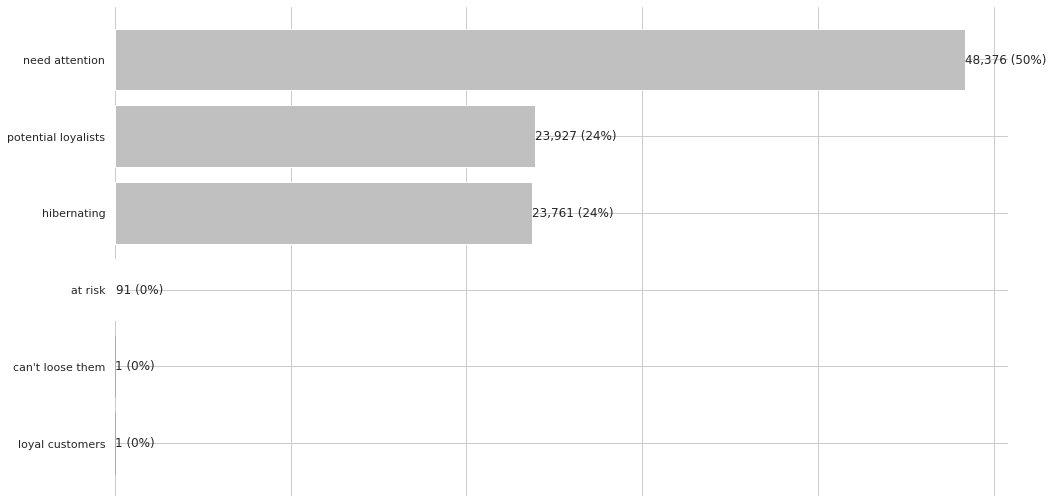

In [126]:
segments_counts = rfm['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['can\'t loose them', 'loyal customers']:
            bar.set_color('darksalmon')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

Выводы:
После проведения сегментации видно, что высок процент потенциальных лояльных пользователей, поэтому можно предположить, что последняя рекламная компания имела успех и привлекла множество новых клиентов, но в тоже время мы понимаем, что больше половины всех пользователей это те, кто либо редко покупают, либо их покупка была совершено давно, из чего можно сделать вывод о том, мы скорее всего продаем товары, которые не нужны часто.

Острых проблем у бизнеса нет, рекламная компания справляется со своей целью, в качестве предложения по укреплению коэффициента удержания пользователей (CRR), можно добавить бонусную программу, а также, если это все-таки тот товар, который пользователи покупают редко (например ноутбуки, телефоны, компьютеры), то разработать программы лояльностей (например, ценностные - только для своих), которые замотивируют вернуться в этот же магазин через долгий промежуток времени, а вдобавок возвращаться чаще за аксессуарами для уже приобретенных единиц, в результате повысятся многие метрики (например, LTV, средний чек, NPS).

In [127]:
#checks.query('student_id not in @active_studs.student_id').shape[0]